# Portein atlas

Image: include four files per sample.
* green: the protein of interest
* blue: nucleus(細胞核)
* red: microtubules(微管)
* yellow: endoplasmic reticulum(內質網)
    
Predict: use green filter image to predict the label, and the other filters are used as references.    

In [1]:
import numpy as np
import pandas as pd
import os
import gc
import re
import cv2
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
from glob import glob # parse the files name
from pathlib import Path
pal = sns.color_palette()

HOME = os.environ['HOME']
data_folder = Path(os.path.join(HOME, 'ninja_project/data/human_protein_atlas'))

In [2]:
os.listdir(str(data_folder))

['test.zip',
 'train.zip',
 'train',
 'train.csv',
 'sample_submission.csv',
 'test']

In [3]:
train_data = pd.read_csv(str(data_folder / 'train.csv'))
train_image_path = data_folder / 'train'
test_image_path = data_folder / 'test'
train_images_list = os.listdir(str(train_image_path))
test_images_list = os.listdir(str(test_image_path))

In [4]:
green_png = glob(str(train_image_path / '*_green.png'))
blue_png = glob(str(train_image_path / '*_blue.png'))
red_png = glob(str(train_image_path / '*_red.png'))
yellow_png = glob(str(train_image_path / '*_yellow.png'))
print(len(green_png), len(blue_png), len(red_png), len(yellow_png))

31072 31072 31072 31072


# Label list

In [5]:
labels_dict = {
0:  "Nucleoplasm", 
1:  "Nuclear membrane",   
2:  "Nucleoli",   
3:  "Nucleoli fibrillar center" ,  
4:  "Nuclear speckles"   ,
5:  "Nuclear bodies"   ,
6:  "Endoplasmic reticulum",   
7:  "Golgi apparatus"   ,
8:  "Peroxisomes"   ,
9:  "Endosomes"   ,
10:  "Lysosomes"   ,
11:  "Intermediate filaments",   
12:  "Actin filaments"   ,
13:  "Focal adhesion sites",   
14:  "Microtubules"   ,
15:  "Microtubule ends",   
16:  "Cytokinetic bridge",   
17:  "Mitotic spindle"   ,
18:  "Microtubule organizing center" ,  
19:  "Centrosome"   ,
20:  "Lipid droplets",   
21:  "Plasma membrane",   
22:  "Cell junctions"  , 
23:  "Mitochondria"   ,
24:  "Aggresome"   ,
25:  "Cytosol",
26:  "Cytoplasmic bodies",   
27:  "Rods & rings" 
}

# Training data 

In [5]:
print('Number of training data: {}'.format(train_data.shape[0]))
print('Number of unique IDs in training data: {}'.format(len(train_data['Id'].unique())))

Number of training data: 31072
Number of unique IDs in training data: 31072


In [6]:
train_data.head()

,Id,Target
0,00070df0-bbc3-11e8-b2bc-ac1f6b6435d0,16 0
1,000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0,7 1 2 0
2,000a9596-bbc4-11e8-b2bc-ac1f6b6435d0,5
3,000c99ba-bba4-11e8-b2b9-ac1f6b6435d0,1
4,001838f8-bbca-11e8-b2bc-ac1f6b6435d0,18


In [7]:
train_data['Target'].isnull().value_counts()

False    31072
Name: Target, dtype: int64

In [6]:
from collections import Counter, defaultdict

labels = train_data['Target'].apply(lambda x: x.split(' '))

count_labels = defaultdict(int)
for line in labels:
    for l in line:
        count_labels[l] += 1
            
mapping_labels = dict()
for k in count_labels.keys():
    mapping_labels[labels_dict[int(k)]] = count_labels[k]


In [31]:
labels_df = pd.DataFrame.from_dict(mapping_labels, orient='index', columns=['count'])
labels_df.reset_index(inplace=True)
labels_df.rename(columns={'index': 'protein'}, inplace=True)

In [32]:
labels_df.head()

,protein,count
0,Microtubule ends,21
1,Centrosome,1482
2,Peroxisomes,53
3,Mitochondria,2965
4,Nuclear speckles,1858


In [34]:
labels_dict = labels_df.to_dict()['count']

In [ ]:
n_labels = 50782

def cls_wts(label_dict, mu=1):
    '''
    linear interpolation of the prior probability of a label being in a class towards equal weights.
    '''
    prob_dict, prob_dict_bal = {}, {}
    max_ent_wt = 1/28 # 要 balance 的機率基準
    for i in range(28):
        prob_dict[i] = label_dict[i]/n_labels
        if prob_dict[i] > max_ent_wt:
            prob_dict_bal[i] = prob_dict[i]-mu*(prob_dict[i] - max_ent_wt)
        else:
            prob_dict_bal[i] = prob_dict[i]+mu*(max_ent_wt - prob_dict[i])            
    return prob_dict, prob_dict_bal

cls_wts(labels_dict)

In [53]:
def create_class_weight(labels_dict, mu=0.5):
    total = sum(labels_dict.values())
    keys = labels_dict.keys()
    class_weight = dict()
    class_weight_log = dict()
    for key in keys:
        score = total / float(labels_dict[key])
        score_log = math.log(mu * total / float(labels_dict[key]))
        class_weight[key] = round(score, 2) if score > 1.0 else round(1.0, 2)
        class_weight_log[key] = round(score_log, 2) if score_log > 1.0 else round(1.0, 2)
    return class_weight, class_weight_log

cw, cwl = create_class_weight(labels_dict)

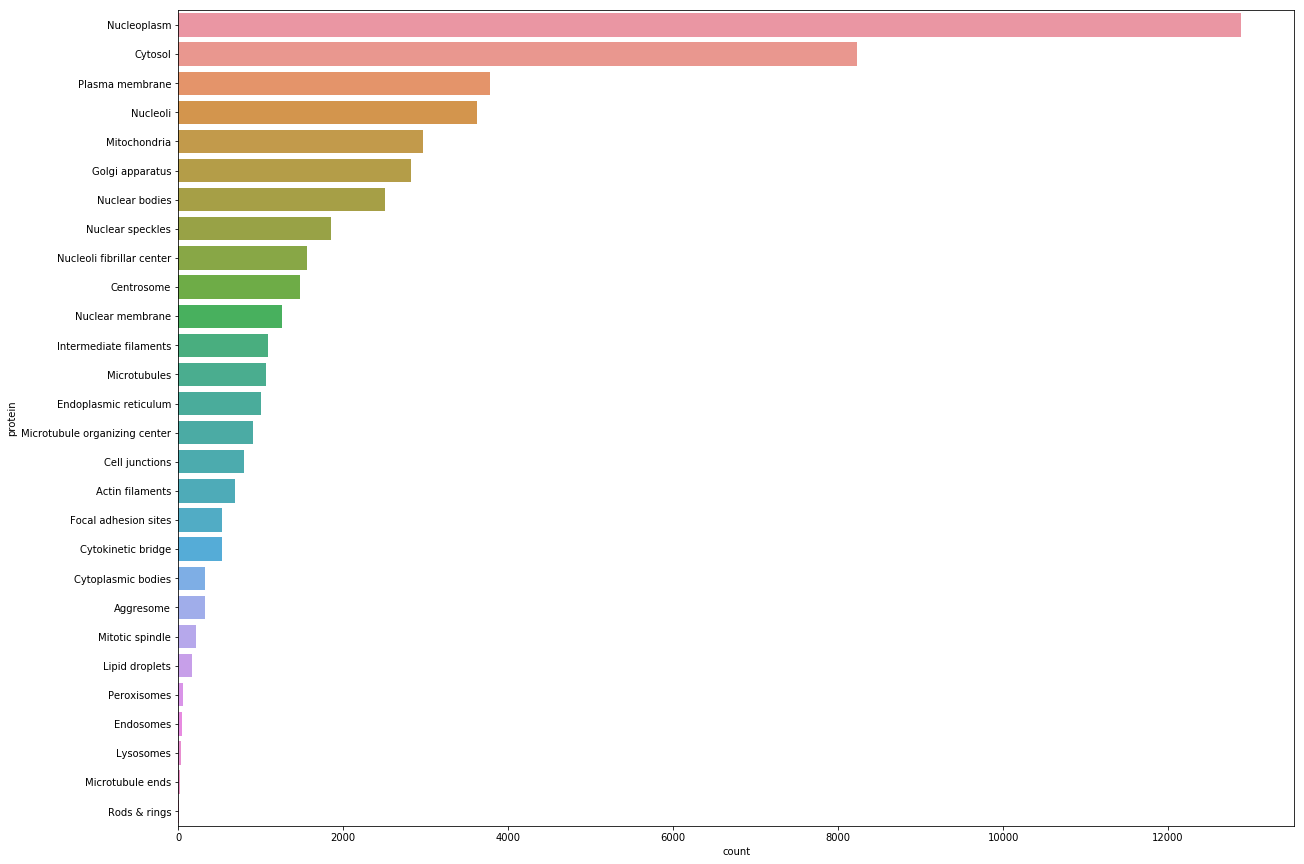

In [12]:
plt.subplots(figsize=(20, 15))
protein_coun_plot = sns.barplot(x="count", y="protein", data=labels_df, orient='h')

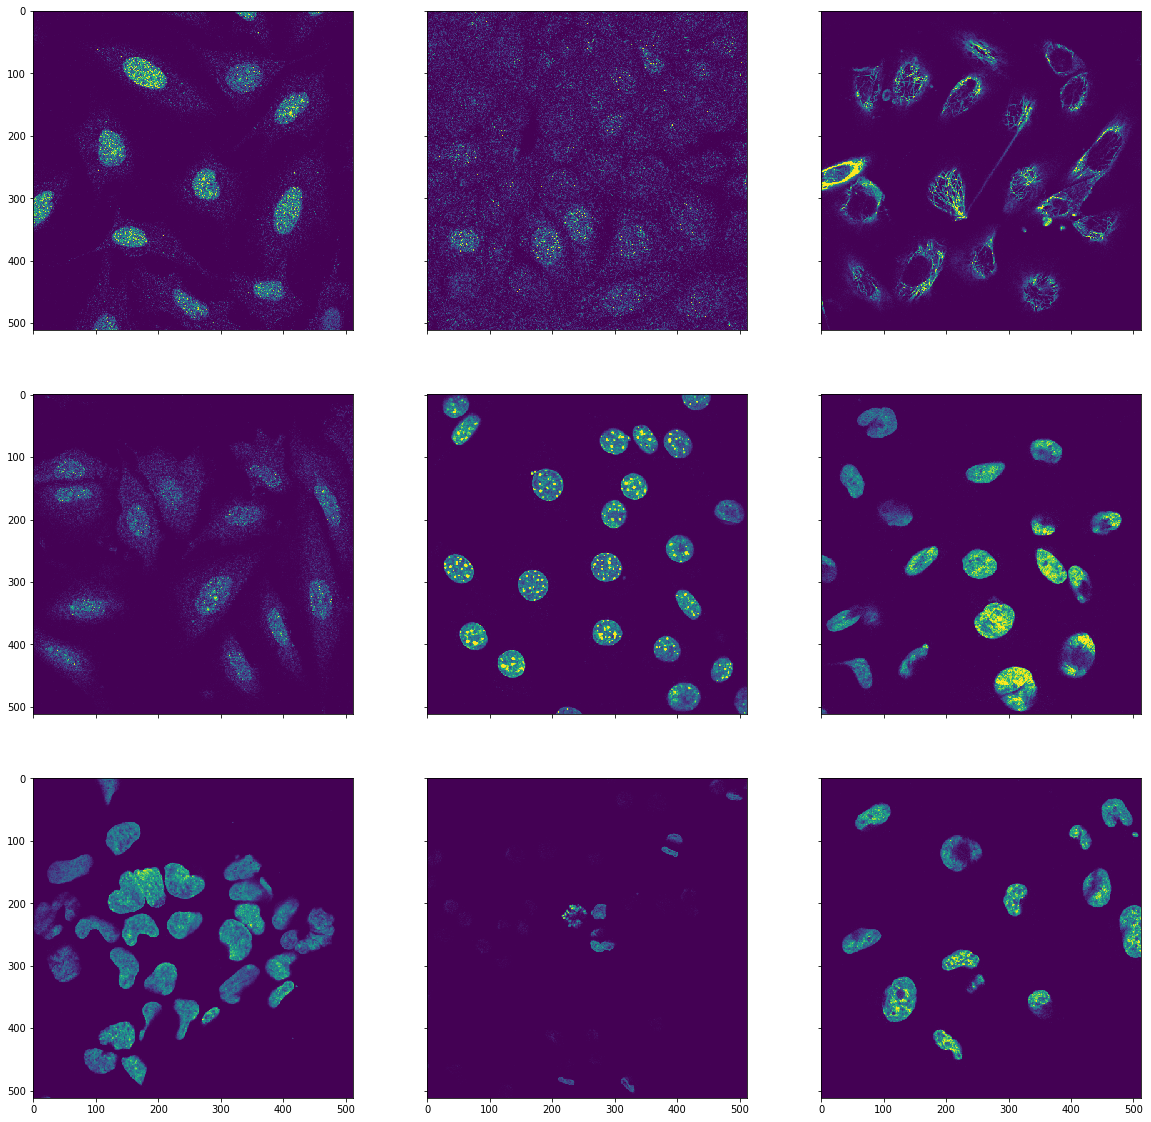

In [13]:
fig, ax = plt.subplots(3, 3, sharex='col', sharey='row')
fig.set_size_inches(20, 20)
for i, imgid in enumerate(train_images_list[0:9]):
    col = i % 3
    row = i // 3
    path = train_image_path / imgid
    img = plt.imread(str(path))
    ax[row, col].imshow(img)    
#image = plt.imread(str(data_folder / 'train' / images[0]))
#plt.title(images[0])
#plt.imshow(image), image.shape

In [14]:
def get_labels(row):
    labels = row.split(' ')
    labels = [int(x) for x in labels]
    return labels
    
train_data['labels'] = train_data['Target'].apply(get_labels)
train_data['nb_labels'] = train_data['labels'].apply(lambda x:len(x))

In [15]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer(classes=np.array(list(labels_dict.keys())))
mulit_label_encoder = mlb.fit_transform(train_data['labels'])
mulit_label_df = pd.DataFrame(mulit_label_encoder, columns=list(labels_dict.values()))
train_data = pd.concat([train_data, mulit_label_df], axis=1)


Text(0.5,1,'Count number of labels')

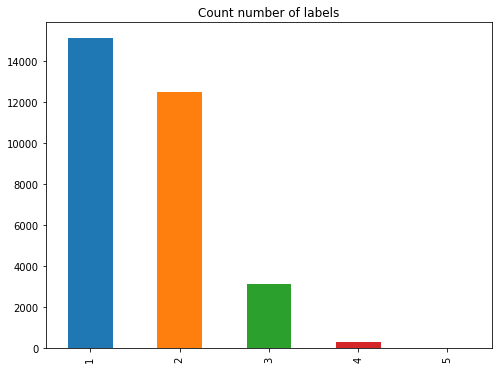

In [16]:
plt.figure(figsize=(8, 6))
train_data['nb_labels'].value_counts().plot('bar')
plt.title('Count number of labels')

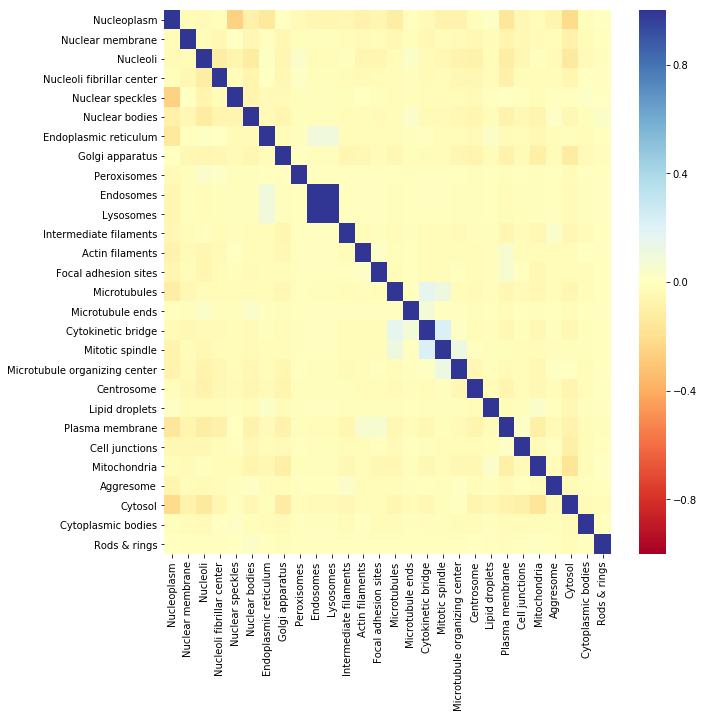

In [89]:
plt.figure(figsize=(10, 10))
sns.heatmap(train_data[train_data['nb_labels']>1].drop(['Id', 'Target', 'labels', 'nb_labels'], 
                                                       axis=1).corr(), cmap='RdYlBu', vmin=-1, vmax=1)


### Conclusion
* In contrast, **endosomes** and **lysosomes** often occur together and somtimes seem to be located at the 
**endoplasmatic reticlum**

* In addition we find that the **mitotic spindle** often comes together with the **cytokinetic bridge**. This makes sense as both are participants for cellular division. And in this process microtubules and thier ends are active and participate as well. Consequently we find a positive correlation between these targets.


# How are special and seldom targets grouped?

Start with those high correlated features

In [28]:
drop_list = ['Id', 'Target', 'labels', 'nb_labels']

def find_counts(special_target, drop_list, data):
    counts = data[data[special_target]==1].drop(drop_list, axis=1).sum(axis=0)
    counts = counts[counts>0]
    counts = counts.sort_values()
    return counts


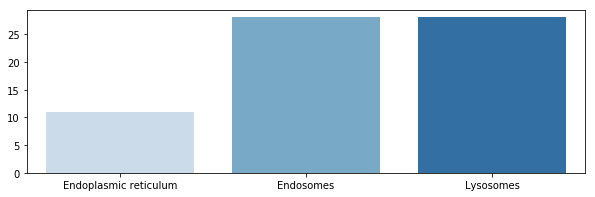

In [31]:
lysosomes_counts = find_counts('Lysosomes', drop_list, train_data)
plt.figure(figsize=(10, 3))
sns.barplot(x=lysosomes_counts.index.values, y=lysosomes_counts.values, palette='Blues')

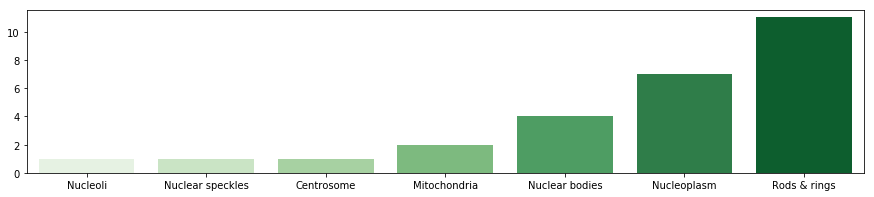

In [32]:
rod_rings_counts = find_counts("Rods & rings", drop_list, train_data)
plt.figure(figsize=(15,3))
sns.barplot(x=rod_rings_counts.index.values, y=rod_rings_counts.values, palette="Greens")


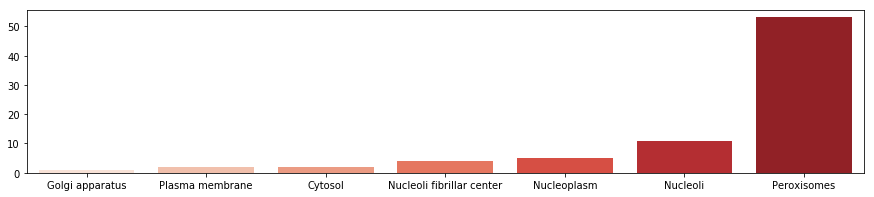

In [35]:
peroxi_counts = find_counts("Peroxisomes", drop_list, train_data)
plt.figure(figsize=(15,3))
sns.barplot(x=peroxi_counts.index.values, y=peroxi_counts.values, palette="Reds")

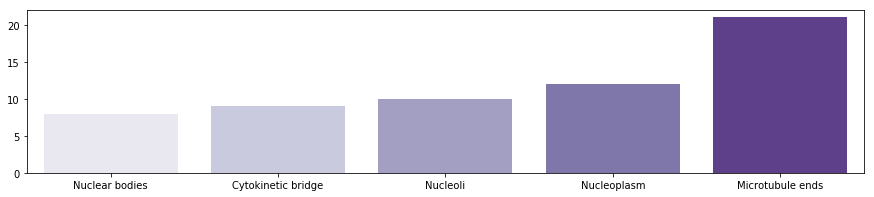

In [36]:
tubeends_counts = find_counts("Microtubule ends", drop_list, train_data)
plt.figure(figsize=(15,3))
sns.barplot(x=tubeends_counts.index.values, y=tubeends_counts.values, palette="Purples")

# How do images of specific targets look like?
While looking at examples, we can build an batch loader

In [ ]:
def load_image(image_id):
    images = np.zeros(shape=(4, 512, 512))
    images[0, :, :] = cv2.imread(train_image_path / image_id / '_green.png')
    images[1, :, :] = cv2.imread(train_image_path / image_id / '_red.png')
    images[2, :, :] = cv2.imread(train_image_path / image_id / '_blue.png')
    images[3, :, :] = cv2.imread(train_image_path / image_id / '_yellow.png')
    return images

def make_image_row(image, subax, title):
    subax[0].imshow(image[0], cmap='Greens')
    subax[1].imshow(image[1], cmap='Reds')
    subax[1].set_title('microtubules')
    subax[2].imshow(image[2], cmap='Blues')
    subax[2].set_title("nucleus")
    subax[3].imshow(image[3], cmap="Oranges")
    subax[3].set_title("endoplasmatic reticulum")
    subax[0].set_title(title)
    return subax
    

In [21]:
# create custom color maps
cdict1 = {'red':((0.0,  0.0, 0.0), (1.0,  0.0, 0.0)),
          'green':((0.0,  0.0, 0.0), (0.75, 1.0, 1.0), (1.0,  1.0, 1.0)),
          'blue':((0.0,  0.0, 0.0), (1.0,  0.0, 0.0))
         }

cdict2 = {'red':((0.0,  0.0, 0.0), (0.75, 1.0, 1.0), (1.0,  1.0, 1.0)),
          'green':((0.0,  0.0, 0.0), (1.0,  0.0, 0.0)),
          'blue':((0.0,  0.0, 0.0), (1.0,  0.0, 0.0))
         }

cdict3 = {'red':((0.0,  0.0, 0.0), (1.0,  0.0, 0.0)),
          'green': ((0.0,  0.0, 0.0), (1.0,  0.0, 0.0)),
          'blue':  ((0.0,  0.0, 0.0), (0.75, 1.0, 1.0), (1.0,  1.0, 1.0))
         }

cdict4 = {'red':((0.0,  0.0, 0.0), (0.75, 1.0, 1.0), (1.0,  1.0, 1.0)),
          'green': ((0.0,  0.0, 0.0), (0.75, 1.0, 1.0), (1.0,  1.0, 1.0)),
          'blue':  ((0.0,  0.0, 0.0), (1.0,  0.0, 0.0))}

plt.register_cmap(name='greens', data=cdict1)
plt.register_cmap(name='reds', data=cdict2)
plt.register_cmap(name='blues', data=cdict3)
plt.register_cmap(name='yellows', data=cdict4)

In [45]:
# get image id
im_id = train_data.loc[1, 'Id']

# get each image channel as a greyscale image (second argument 0 in imread)
green = cv2.imread(str(train_image_path / '{}_green.png'.format(im_id)), cv2.IMREAD_GRAYSCALE)
red = cv2.imread(str(train_image_path / '{}_red.png'.format(im_id)), cv2.IMREAD_GRAYSCALE)
blue = cv2.imread(str(train_image_path / '{}_blue.png'.format(im_id)), 0)
yellow = cv2.imread(str(train_image_path / '{}_yellow.png'.format(im_id)), 0)


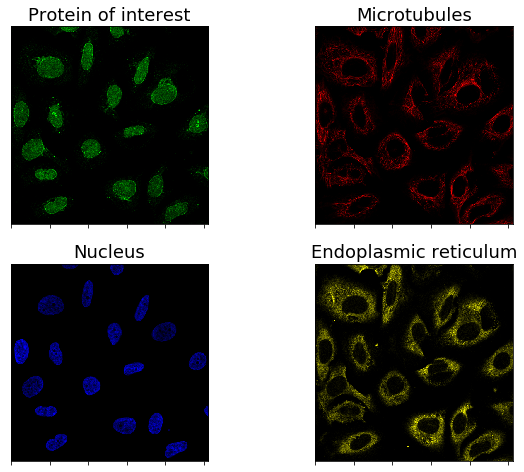

In [57]:
#display each channel separately
fig, ax = plt.subplots(nrows = 2, ncols=2, figsize=(10, 8))
ax[0, 0].imshow(green, cmap="greens")
ax[0, 0].set_title("Protein of interest", fontsize=18)
ax[0, 1].imshow(red, cmap="reds")
ax[0, 1].set_title("Microtubules", fontsize=18)
ax[1, 0].imshow(blue, cmap="blues")
ax[1, 0].set_title("Nucleus", fontsize=18)
ax[1, 1].imshow(yellow, cmap="yellows")
ax[1, 1].set_title("Endoplasmic reticulum", fontsize=18)
for i in range(2):
    for j in range(2):
        ax[i, j].set_xticklabels([])
        ax[i, j].set_yticklabels([])
        ax[i, j].tick_params(left=False, right=False)
plt.show()        



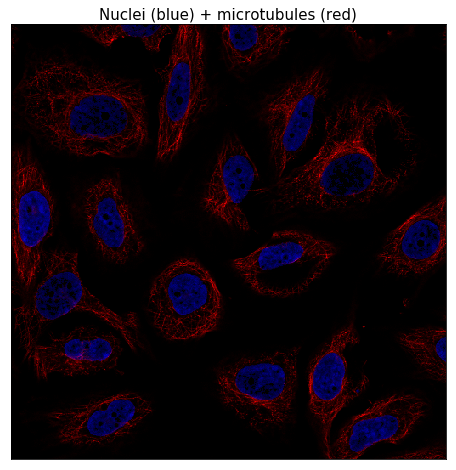

In [78]:
# stack nucleus(blue) and microtubules(red) images
# create blue nucleus and red microtubules images
nuclei = cv2.merge((np.zeros((512, 512), dtype='uint8'), np.zeros((512, 512), dtype='uint8'), blue))
microtub = cv2.merge((red, np.zeros((512, 512),dtype='uint8'), np.zeros((512, 512),dtype='uint8')))

# create ROI
row, cols, _ = nuclei.shape
roi = microtub[:row, :cols]

# create a mask of nuclei and invert mask
nuclei_grey = cv2.cvtColor(nuclei, cv2.COLOR_BGR2GRAY)
ret, mask = cv2.threshold(nuclei_grey, 10, 255, cv2.THRESH_BINARY)
mask_inv = cv2.bitwise_not(mask)

# mask area of nuclei in ROI black
red_bg = cv2.bitwise_and(roi, roi)

# select only region with nuclei from blue
blue_fg = cv2.bitwise_and (nuclei, nuclei, mask=mask)

# put nuclei in ROI and modify red 
dst = cv2.add(red_bg, blue_fg)
microtub[:row, :cols] = dst

#show result image
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(microtub)
ax.set_title("Nuclei (blue) + microtubules (red)", fontsize=15)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.tick_params(left=False, bottom=False)


In [79]:
color_mapping = {
    'green': 'the protein of interest',
    'blue': 'nucleus',
    'red': 'microtubules',
    'yellow': 'endoplasmic reticulum'
}

Label: Lipid droplets


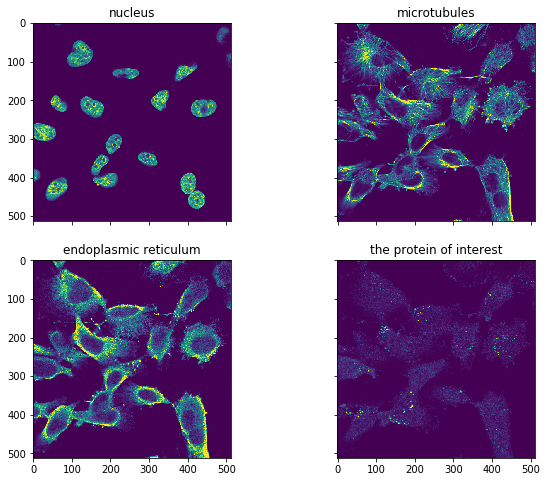

In [81]:
idx = 20
sample_df = train_data[train_data['nb_labels'] == 1].iloc[idx]
sample_id = sample_df['Id']
smaple_image_files = glob(str(train_image_path / (sample_id + '*')))

labels_value = sample_df.iloc[4:-1]
print('Label: {}'.format(labels_value[labels_value == 1].keys()[0]))
fig, ax = plt.subplots(2, 2, sharex='col', sharey='row')
fig.set_size_inches(10, 8)
for i, imgid in enumerate(smaple_image_files):
    col = i % 2
    row = i // 2
    path = train_image_path / imgid
    img = plt.imread(str(path))
    name_mapping = color_mapping[re.findall('_\w+\.png$', imgid)[0].replace('_', '').replace('.png', '')]
    ax[row, col].set_title(name_mapping)
    ax[row, col].imshow(img)  

# Building a baseline model

In [48]:
print('The test set size turns out to be {:.2f}% compared to the train set'.format(
    np.round(len(test_images_list) / len(train_images_list) * 100)))
      
    

The test set size turns out to be 38.00% compared to the train set


### K-Fold Cross-Validation

As our test data is 38 % of size compared to the train set it makes sense to use 3-Fold cross validation where the test set is 33 % of size compared to the train set. As we are working with neural networks that can be demanding in computational resources, let's only use 2 repetitions.

In [50]:
from sklearn.model_selection import RepeatedKFold
splitter = RepeatedKFold(n_splits=3, n_repeats=1, random_state=0)


This splitter is now a generator. Hence if you call splitters split method it will yield one Fold of the repeated K-Folds. Consequently if we choose n_repeats=2 we will end up with 6 Folds in total: 3 Folds for the first cross validation and again 3 Folds for the repeated cross validation. We will perform the splitting on the image ids. This way we can easily load images and targets given the chunk ids. Due to performance reasons I will only use one cv-fold to explore results and one repeat!

In [52]:
partitions = []
for train_idx, test_idx in splitter.split(train_data.index.values):
    partition = {}
    partition['training'] = train_data.Id.values[train_idx]    
    partition['validation'] = train_data.Id.values[test_idx]
    partitions.append(partition)


In [56]:
class ModelParameters:
    def __init__(self, basepath, n_classes=28, image_rows=512, image_cols=512, batch_size=200, n_channels=1, 
                 row_scale_factor=4, col_scale_factor=4, shuffle=False, n_epochs=1):
        self.basepath = basepath
        self.n_classes = n_classes
        self.image_rows = image_rows
        self.image_cols = image_cols
        self.batch_size = batch_size
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.row_scale_factor = row_scale_factor
        self.col_scale_factor = col_scale_factor
        self.scaled_row_dim = np.int(self.image_rows / self.row_scale_factor)
        self.scaled_col_dim = np.int(self.image_cols / self.col_scale_factor)
        self.n_epochs = n_epochs
        
model_parameters = ModelParameters(train_image_path)        

In [61]:
from skimage.transform import resize 

class ImagePreprocessor:
    def __init__(self, model_parameter):
        self.parameter = model_parameter
        self.basepath = self.parameter.basepath
        self.scaled_row_dim = self.parameter.scaled_row_dim
        self.scaled_col_dim = self.parameter.scaled_col_dim
        self.n_channels = self.parameter.n_channels
    
    def preprocess(self, image):
        image = self.img_resize(image)
        image = self.img_reshape(image)
        image = self.img_normalize(image)
        return image
        
    def img_resize(self, image):
        image = resize(image, (self.scaled_row_dim, self.scaled_col_dim))
        return image

    def img_reshape(self, image):
        image = np.reshape(image, (image.shape[0], image.shape[1], self.n_channels))
        return image
    
    def img_normalize(self, image):
        image /= 255
        return image
    
    def load_image(self, image_id):
        images = np.zeros(shape=(4, 512, 512))
        images[0, :, :] = cv2.imread(self.basepath / image_id / '_green.png')
        images[1, :, :] = cv2.imread(self.basepath / image_id / '_red.png')
        images[2, :, :] = cv2.imread(self.basepath / image_id / '_blue.png')
        images[3, :, :] = cv2.imread(self.basepath / image_id / '_yellow.png')
        return images
    
image_preprocessor = ImagePreprocessor(model_parameters)    

In [62]:
import keras 

class DataGenerator(keras.utils.Sequence):
    def __init__(self, list_ids, labels, _model_parameters, _image_preprocessor, drop_list):
        self.params = _model_parameters
        self.labels = labels # each Id of the dataset
        self.list_ids = list_ids
        self.dim =(self.params.scaled_row_dim, self.params.scaled_col_dim)
        self.batch_size = self.params.batch_size
        self.n_channels = self.params.n_channels
        self.n_classes = self.n_classes
        self.shuffle = self.params.shuffle
        self.preprocessor = _image_preprocessor
        self.on_epoch_end()
        self.drop_list = drop_list
    
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.list_ids))
        if self.shuffle:
            np.random.shuffle(self.indexes)
    
    def get_targets_per_image(self, identifier):
        return self.labels.loc(self.labels.Id == identifier).drop(self.drop_list, axis=1).values
    
    def __data_generation(self, list_ids_temp):
        # initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size, self.n_classes), dtype=int)
        
        for i, identifier in enumerate(list_ids_temp):
            image = self.preprocessor.load_image(identitifer)
            image = self.preprocessor.preprocessor(image)
            X[i] = image
            y[i] = self.get_targets_per_image(identitifer)
        return X, y 
    
    def __len__(self):
        "Denotes the number of batches per epoch"
        return int(np.floor(len(self.list_ids) / self.batch_size))
    
    def __getitem__(self, index):
        "Generate one batch of data"
        indexes = self.indexes[index * self.batch_size: (index + 1) * self.bath_size]        
        list_ids_temp = [self.list_ids[k] for k in indexes]
        X, y = self.__data_generation(list_ids_temp)
        return X, y
    
        
        

Using TensorFlow backend.


In [ ]:
class PredictGenerator:
    def __init__(self, predict_ids, _image_preprocessor, predict_path):
        self.preprocessor = _image_preprocessor
        self.preprocessor.basepath = predict_path
        self.identifiers = predict_ids
        
    def predict(self, model):
        y = np.empty(shape=(len(self.identifiers), self.preprocessor.n_classes))
        for n in range(len(self.identifiers)):
            image = self.preprocessor.load_image(self.identifiers[n])
            image = self.preprocessor.preprocess(image)
            image = image.reshape((1, *image.shape))
            y[n] = model.predict(image)
        return y
    

In [63]:
from keras import models, layers
from keras import losses, optimizers
from keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau
from keras import backend as K
from keras.utils import multi_gpu_model

class BaseLineModel:
    def __init__(self, _model_parameters):
        self.params = _model_parameters
        self.n_classes = self.params.n_classes
        self.img_row = self.params.scaled_row_dim
        self.img_col = self.params.scaled_col_dim
        self.n_channels = self.params.n_channels
        self.input_shape = (self.img_rows, self.img_cols, self.n_channels)

    def build_model(self):
        x = layers.Input(self.input_shape, name='Img_input')
        